## 1. Import libraries

In [5]:
! pip install split-folders

In [64]:
import os
import cv2
import numpy as np
import matplotlib.cm as cm
import tensorflow as tf
import random
import PIL
from PIL import Image, ImageOps
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import mobilenet
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.metrics import categorical_crossentropy

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import splitfolders
%matplotlib inline

## 2. Data preparation

In [25]:
splitfolders.ratio('rooms_dataset_simple', output="rooms_dataset_test", seed=30, ratio=(0.8, 0.1, 0.1)) 

In [27]:
os.listdir(f'rooms_dataset_test/train')  # Directory where training data folders are

['baño', 'exterior', 'zonas_comunes', 'zona_comercial', 'cocina', 'habitación']

In [28]:
num_classes = len(os.listdir(f'rooms_dataset_test/train'))
dataset_dir ="rooms_dataset_test"
batch_size = 32  # Training batch size
print(num_classes)

6


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# preprocessing image and divide validaiton set
train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                   brightness_range=[0.5,1.5], 
                                   zoom_range=[0.3,1], 
                                   rotation_range=5)

train_generator = train_datagen.flow_from_directory(dataset_dir+'/train',
                                                 target_size=(224,224),
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='training')

validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(dataset_dir+'/val',
                                                            target_size=(224,224),
                                                            batch_size=batch_size,
                                                            class_mode='categorical')

test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(dataset_dir+'/test',
                                                            target_size=(224,224),
                                                            batch_size=batch_size,
                                                            class_mode='categorical')



Found 815 images belonging to 6 classes.
Found 100 images belonging to 6 classes.
Found 106 images belonging to 6 classes.


In [30]:
classes = train_generator.class_indices
print(classes)

{'baño': 0, 'cocina': 1, 'exterior': 2, 'habitación': 3, 'zona_comercial': 4, 'zonas_comunes': 5}


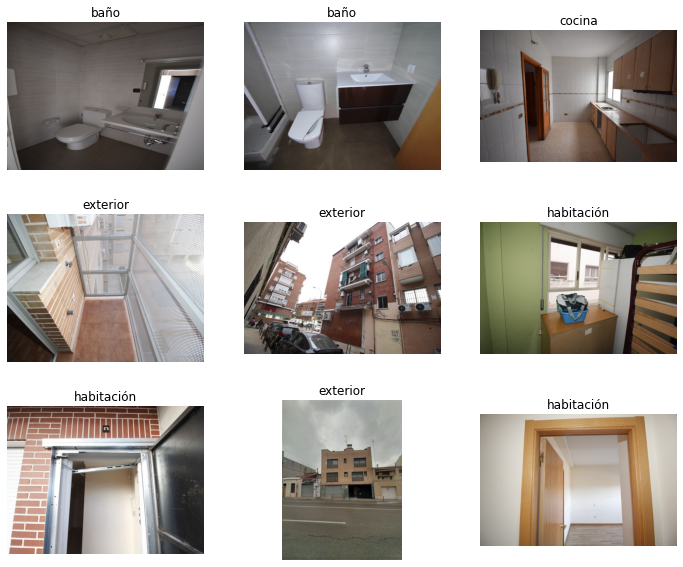

In [31]:
class_names = list(classes.keys())

fig, axes = plt.subplots(3,3, figsize=(12, 10))
indices = np.random.randint(0, 624, size=9)
for i, ax in enumerate(axes.flatten()):
    indx = indices[i]
    im = Image.open(train_generator.filepaths[indx])
    ax.imshow(im)
    ax.set_title(class_names[train_generator.classes[indx]])
    ax.axis('off')

## 3. Download network

In [32]:
#Get the places356 weights
weights_file = 'vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_path = tf.keras.utils.get_file(weights_file, 'https://github.com/GKalliatakis/Keras-VGG16-places365/releases/download/v1.0/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [33]:
base_model = vgg16.VGG16(weights = weights_path , include_top=False, input_shape = (224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [34]:
# iterate through its layers and lock them to make them not trainable with this code
for layer in base_model.layers:
    layer.trainable = False

#ine_tune=2
#if fine_tune es decir cuantas capas quieres reentrenar
#or layer in base_model.layers[:-fine_tune]:
#   layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = base_model.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten(name="flatten")(last_layer)

# add two FC layers, 50 and 20 units and relu activation 
x = Dense(50, activation='relu')(x)
x = Dense(30, activation='relu')(x)

x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)
vgg_model = Model(inputs=base_model.input, outputs=x)
# print the new_model summary
new_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [36]:
new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
from livelossplot.inputs.keras import PlotLossesCallback
plot_loss = PlotLossesCallback()

In [39]:
import math
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K

early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')

checkpoint = ModelCheckpoint('logs/ep{epoch:03}-val_accuracy{val_accuracy:.3f}.h5', monitor='val_accuracy',save_best_only=True, verbose=1)

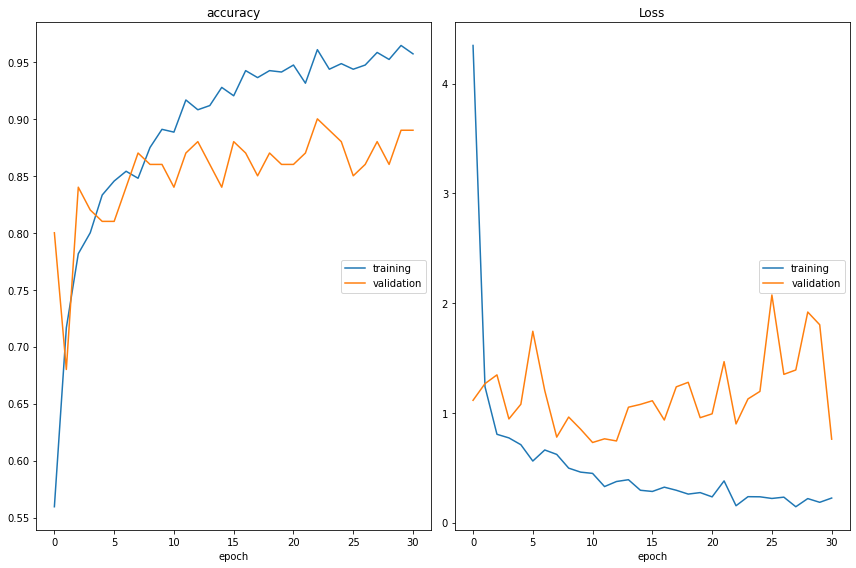

accuracy
	training         	 (min:    0.560, max:    0.964, cur:    0.957)
	validation       	 (min:    0.680, max:    0.900, cur:    0.890)
Loss
	training         	 (min:    0.144, max:    4.348, cur:    0.223)
	validation       	 (min:    0.729, max:    2.073, cur:    0.760)
26/26 - 151s - loss: 0.2230 - accuracy: 0.9571 - val_loss: 0.7596 - val_accuracy: 0.8900 - 151s/epoch - 6s/step


In [40]:
history = new_model.fit(train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=100, verbose=2, callbacks=[checkpoint, early_stop, plot_loss])

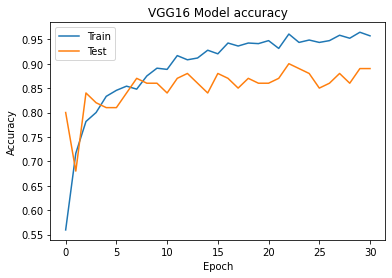

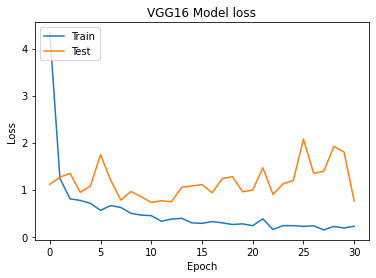

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = new_model.predict_generator(test_generator, 211 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

#Evaluating using Keras model_evaluate:
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

/tmp/ipykernel_168886/1791578091.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(test_generator, 211 // batch_size+1)


Confusion Matrix
[[ 2  1  3  5  2  2]
 [ 0  0  2  5  0  2]
 [ 4  4  9  7  2  3]
 [ 6  2  9 12  2  4]
 [ 1  0  1  1  2  1]
 [ 1  0  5  5  0  1]]
Classification Report
                precision    recall  f1-score   support

          baño       0.14      0.13      0.14        15
        cocina       0.00      0.00      0.00         9
      exterior       0.31      0.31      0.31        29
    habitación       0.34      0.34      0.34        35
zona_comercial       0.25      0.33      0.29         6
 zonas_comunes       0.08      0.08      0.08        12

      accuracy                           0.25       106
     macro avg       0.19      0.20      0.19       106
  weighted avg       0.24      0.25      0.24       106

4/4 [==============================] - 18s 4s/step - loss: 1.9408 - accuracy: 0.8491
Accuracy:  0.849056601524353
Loss:  1.940755009651184


In [47]:
# Generate predictions
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preloaded_weights = []
for pre in new_model.layers:
    preloaded_weights.append(pre.get_weights())

# load pre-trained weights
vgg_model.load_weights('logs/ep023-val_accuracy0.900.h5', by_name=True) # initialize the best trained weights

# compare previews weights vs loaded weights
for layer, pre in zip(vgg_model.layers, preloaded_weights):
    weights = layer.get_weights()

    if weights:
        if np.array_equal(weights, pre):
            print('not loaded', layer.name)
        else:
            print('loaded', layer.name)


loaded block1_conv1
loaded block1_conv2
loaded block2_conv1
loaded block2_conv2
loaded block3_conv1
loaded block3_conv2
loaded block3_conv3
loaded block4_conv1
loaded block4_conv2
loaded block4_conv3
loaded block5_conv1
loaded block5_conv2
loaded block5_conv3
loaded dense_2
loaded dense_3
loaded softmax


In [63]:
from sklearn.metrics import accuracy_score

y_pred = vgg_model.predict(x_test, batch_size=32)
y_pred1D = y_pred.argmax(1)
y_test1D = y_test.argmax(1)
test_accuracy = accuracy_score(y_test1D, y_pred1D)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(test_accuracy * 100))

4/4 [==============================] - 17s 4s/step
VGG16 Model Accuracy without Fine-Tuning: 84.91%


### Fine-tuning

In [76]:
# Reset our image data generators
train_generator.reset()
validation_generator.reset()
test_generator.reset()

In [77]:
base_model = vgg16.VGG16(weights = weights_path , include_top=False, input_shape = (224, 224, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [78]:
fine_tune=2
for layer in base_model.layers[:-fine_tune]:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [79]:
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# save the output of the last layer to be the input of the next layer
last_layer = base_model.output

# flatten the classifier input which is output of the last layer of VGG16 model
x = Flatten(name="flatten")(last_layer)

# add two FC layers, 50 and 20 units and relu activation 
x = Dense(50, activation='relu')(x)
x = Dense(30, activation='relu')(x)

x = Dense(num_classes, activation='softmax', name='softmax')(x)

# instantiate a new_model using keras’s Model class
new_model = Model(inputs=base_model.input, outputs=x)
vgg_model = Model(inputs=base_model.input, outputs=x)
# print the new_model summary
new_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [80]:
plot_loss_ft = PlotLossesCallback()

In [81]:
new_model.compile(optimizer=RMSprop(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

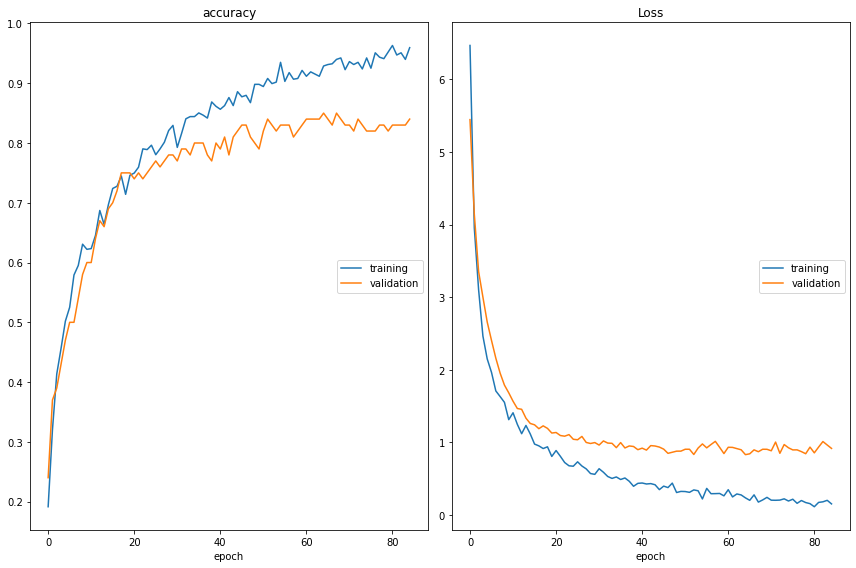

accuracy
	training         	 (min:    0.191, max:    0.963, cur:    0.960)
	validation       	 (min:    0.240, max:    0.850, cur:    0.840)
Loss
	training         	 (min:    0.113, max:    6.468, cur:    0.152)
	validation       	 (min:    0.831, max:    5.447, cur:    0.917)
26/26 - 154s - loss: 0.1523 - accuracy: 0.9595 - val_loss: 0.9167 - val_accuracy: 0.8400 - 154s/epoch - 6s/step


In [82]:
history = new_model.fit(train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=200, verbose=2, callbacks=[checkpoint, early_stop, plot_loss_ft])

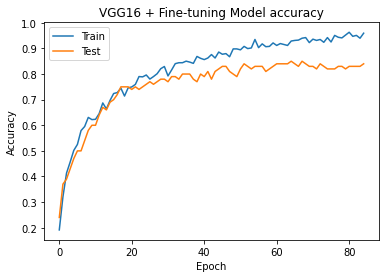

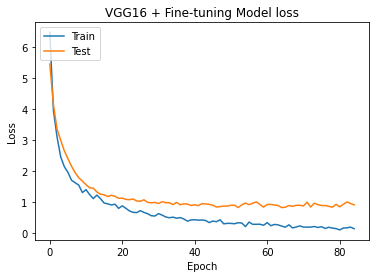

In [83]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 + Fine-tuning Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 + Fine-tuning Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [84]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

Y_pred = new_model.predict_generator(test_generator, 211 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=class_names))

#Evaluating using Keras model_evaluate:
x, y = zip(*(test_generator[i] for i in range(len(test_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = new_model.evaluate(x_test, y_test, batch_size=32)

print("Accuracy: " ,acc)
print("Loss: ", loss)

/tmp/ipykernel_168886/1791578091.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = new_model.predict_generator(test_generator, 211 // batch_size+1)


Confusion Matrix
[[ 3  0  5  4  1  2]
 [ 0  1  2  5  0  1]
 [ 4  3 11  8  2  1]
 [ 7  2  7 14  3  2]
 [ 1  0  2  1  0  2]
 [ 2  1  4  3  1  1]]
Classification Report
                precision    recall  f1-score   support

          baño       0.18      0.20      0.19        15
        cocina       0.14      0.11      0.12         9
      exterior       0.35      0.38      0.37        29
    habitación       0.40      0.40      0.40        35
zona_comercial       0.00      0.00      0.00         6
 zonas_comunes       0.11      0.08      0.10        12

      accuracy                           0.28       106
     macro avg       0.20      0.20      0.20       106
  weighted avg       0.28      0.28      0.28       106

4/4 [==============================] - 17s 4s/step - loss: 0.9197 - accuracy: 0.8302
Accuracy:  0.8301886916160583
Loss:  0.919728696346283


In [85]:
new_model.save("logs/model_ft_acc83.h5")

In [86]:
# Generate predictions
true_classes = test_generator.classes
class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

preloaded_weights = []
for pre in new_model.layers:
    preloaded_weights.append(pre.get_weights())

# load pre-trained weights
vgg_model.load_weights('logs/model_ft_acc83.h5', by_name=True) # initialize the best trained weights

# compare previews weights vs loaded weights
for layer, pre in zip(vgg_model.layers, preloaded_weights):
    weights = layer.get_weights()

    if weights:
        if np.array_equal(weights, pre):
            print('not loaded', layer.name)
        else:
            print('loaded', layer.name)


loaded block1_conv1
loaded block1_conv2
loaded block2_conv1
loaded block2_conv2
loaded block3_conv1
loaded block3_conv2
loaded block3_conv3
loaded block4_conv1
loaded block4_conv2
loaded block4_conv3
loaded block5_conv1
loaded block5_conv2
loaded block5_conv3
loaded dense_6
loaded dense_7
loaded softmax


/home/irene/tfm_env/tfm_env/lib/python3.8/site-packages/numpy/core/numeric.py:2457: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a1, a2 = asarray(a1), asarray(a2)


In [88]:
from sklearn.metrics import accuracy_score

y_pred = vgg_model.predict(x_test, batch_size=32)
y_pred1D = y_pred.argmax(1)
y_test1D = y_test.argmax(1)
test_accuracy = accuracy_score(y_test1D, y_pred1D)
print("VGG16 Model Accuracy with Fine-Tuning: {:.2f}%".format(test_accuracy * 100))

4/4 [==============================] - 17s 4s/step
VGG16 Model Accuracy with Fine-Tuning: 83.02%
